# Notebook 4: Machine Learning to Infer SpaceX Launch Weather Constraints

## Objective
This notebook applies supervised machine learning to historical SpaceX launch
weather conditions in order to **infer implicit weather-related launch constraints**.
Because formal launch commit criteria are not publicly available and weather-related
scrubs are rare, the goal is not to perfectly predict scrubs, but to learn the
*operational envelope* within which SpaceX has demonstrated it is willing to launch.

---

## Input data
The dataset used here merges:
- SpaceX launch times and metadata (Notebook 1)
- ERA5 atmospheric reanalysis at Kennedy Space Center (Notebook 2)
- Offshore significant wave height as a proxy for recovery/landing constraints
- Time-derived features (launch hour, month, season)

All samples correspond to **actual launches** between 2010–2024.

---

## Why multiple target definitions are explored
Public scrub labels are sparse and inconsistent. To address this, two related but
distinct modeling approaches are tested:

### 1. Weather-issue classification
A conservative binary label (`weather_issue_flag`) is constructed using natural
language processing on launch descriptions to identify explicitly weather-related
scrubs. This task demonstrates traditional classification performance but suffers
from extreme class imbalance.

### 2. Severity-based near-envelope classification (primary model)
A continuous **severity score** is constructed by normalizing key meteorological
variables and measuring how close each launch was to the most restrictive observed
conditions. Launches in the top tail (e.g., 95th percentile) are labeled as
**near-envelope** cases.

This framing allows the model to learn *how close to operational limits* a launch was,
rather than relying on noisy scrub labels.

---

## Machine learning methods used
The following models and techniques from ATMS 523 are applied:

- **Logistic Regression**
  - Used as a baseline, interpretable classifier
  - Provides physically interpretable coefficients
  - Evaluated using ROC AUC, precision, recall, and class imbalance awareness

- **Random Forest Classifier**
  - Captures nonlinear relationships between weather variables
  - Provides feature importance for physical interpretation
  - Demonstrates improved discrimination for rare near-envelope cases

- **Train/test splits**
  - Used to assess generalization
  - Avoids overfitting on a small, imbalanced dataset

- **ROC AUC**
  - Primary performance metric due to severe class imbalance
  - More informative than raw accuracy for rare-event detection

---

## Key results and physical interpretation
The near-envelope model achieves high ROC AUC, indicating strong separation between
typical launch conditions and the most restrictive cases.

Feature importance analysis shows that:
- Launch hour (diurnal effects)
- Surface wind speed
- Cloud cover
- Offshore sea state
- Near-surface temperature

are the dominant drivers of near-envelope risk, consistent with known launch
meteorology and recovery constraints.

Importantly, metadata variables (e.g., rocket family, season labels) play a minimal
role, indicating the model is learning **environmental constraints rather than
administrative artifacts**.

---

## Why this framing is appropriate
This notebook does **not** assume SpaceX launches beyond official placards.
Instead, it assumes that **historical launches define the interior of an acceptable
weather envelope**, and that proximity to the envelope boundary represents increased
weather risk.

This approach is well suited for:
- Sparse labels
- Operational decision inference
- Downstream forecast-based decision support (Notebook 5)

---

## Limitations
- Scrub labels are incomplete and may include non-weather technical issues.
- Reanalysis data may differ from the exact forecasts used operationally.
- The dataset is relatively small (~150 launches), limiting model complexity.

Despite these limitations, the results demonstrate how data-driven methods can
approximate real-world aerospace weather decision-making.

---

## Connection to Notebook 5
The trained near-envelope classifier is exported and used in Notebook 5, where
**forecast data** replaces reanalysis data to produce a user-facing
**percent confidence of launch weather suitability**.

Together, Notebooks 1–5 form a complete workflow:
data acquisition → feature engineering → machine learning → operational inference.


In [33]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay
)

plt.style.use("seaborn-v0_8")

data_dir = Path("data")


In [34]:
df = pd.read_csv(
    data_dir / "spacex_era5_ksc_droneship_2010_2024.csv",
    parse_dates=["date_utc"]
)

df.head()

df["date_hour"] = df["date_utc"].dt.floor("h")
df["launch_hour"] = df["date_hour"].dt.hour
df["launch_month"] = df["date_hour"].dt.month

def month_to_season(m):
    if m in [12, 1, 2]:
        return "DJF"
    elif m in [3, 4, 5]:
        return "MAM"
    elif m in [6, 7, 8]:
        return "JJA"
    else:
        return "SON"

df["season"] = df["launch_month"].apply(month_to_season)

df[["date_utc", "launch_hour", "launch_month", "season"]].head()


def flag_any_scrub_or_failure(details: str) -> bool:
    if not isinstance(details, str):
        return False
    text = details.lower()
    keywords = [
        "scrub", "scrubbed", "abort", "aborted",
        "delayed", "delay", "postpone", "postponed",
        "failure", "failed", "anomaly",
    ]
    return any(kw in text for kw in keywords)

def classify_scrub_reason(details: str) -> str:
    if not isinstance(details, str):
        return "unknown"
    text = details.lower()

    weather_keywords = [
        "weather", "upper-level winds", "upper level winds",
        "lightning", "storm", "rain", "thick cloud",
        "cloud rule", "anvil", "cumulus", "unfavorable conditions",
    ]

    technical_keywords = [
        "engine", "merlin", "valve", "sensor", "pressur",
        "computer", "autosequence", "guidance", "leak",
        "fuel", "oxidizer", "fairing", "hardware", "propellant",
    ]

    range_keywords = [
        "range violation", "range held", "boat in", "ship in",
        "keep-out zone", "airspace", "danger zone",
    ]

    if any(kw in text for kw in weather_keywords):
        return "weather"
    if any(kw in text for kw in technical_keywords):
        return "technical"
    if any(kw in text for kw in range_keywords):
        return "range"
    return "unknown"

df["text_scrub_like"] = df["details"].apply(flag_any_scrub_or_failure)
df["scrub_reason"] = df["details"].apply(classify_scrub_reason)
df["weather_issue_flag"] = (df["scrub_reason"] == "weather").astype(int)

print("scrub_reason counts:")
print(df["scrub_reason"].value_counts())
print("\nweather_issue_flag counts:")
print(df["weather_issue_flag"].value_counts())



scrub_reason counts:
scrub_reason
unknown      134
technical     16
weather        4
Name: count, dtype: int64

weather_issue_flag counts:
weather_issue_flag
0    150
1      4
Name: count, dtype: int64


In [ ]:
vars_core = ["wind_speed_10m", "t2m_C", "tcc_frac", "tp_mmhr", "cp_mmhr", "msl", "swh"]

percentile = 1
placards_df = df[vars_core].quantile(percentile).to_frame(name=f"{int(percentile*100)}th_percentile")
placards = placards_df.iloc[:, 0]

placards

# Add a tiny epsilon on precip to avoid division by zero
eps = 1e-6

df["severity_score"] = (
    (df["wind_speed_10m"] / placards["wind_speed_10m"]) +
    (df["tcc_frac"] / max(placards["tcc_frac"], eps)) +
    (df["tp_mmhr"] / (placards["tp_mmhr"] + eps)) +
    (df["swh"] / (placards["swh"] + eps))
)

df["severity_score"].describe()


df["too_bad_flag"] = (df["severity_score"] > 4.0).astype(int)
df["too_bad_flag"].value_counts()


too_bad_flag
0    154
Name: count, dtype: int64

In [36]:
target_col = "weather_issue_flag"

numeric_features = [
    "wind_speed_10m",
    "t2m_C",
    "tcc_frac",
    "tp_mmhr",
    "cp_mmhr",
    "msl",
    "swh",
    "launch_hour",
    "launch_month",
]

categorical_features = []
if "rocket_name" in df.columns:
    categorical_features.append("rocket_name")
if "season" in df.columns:
    categorical_features.append("season")

all_feature_cols = numeric_features + categorical_features

# Drop rows missing target or any numeric feature
df_model = df.dropna(subset=[target_col] + numeric_features).copy()

X = df_model[all_feature_cols]
y = df_model[target_col].astype(int)

print("X shape:", X.shape)
print("Target distribution:\n", y.value_counts())


X shape: (154, 11)
Target distribution:
 weather_issue_flag
0    150
1      4
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y,
)

X_train.shape, X_test.shape


((115, 11), (39, 11))

In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop",
)

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

log_reg_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs"
    )),
])

rf_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        class_weight="balanced",
        min_samples_leaf=2
    )),
])


In [ ]:
log_reg_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

# ---------------------------------------
# Rebuild feature names after preprocessing
# ---------------------------------------

# Numeric feature names (unchanged)
num_feature_names = numeric_features

# Categorical feature names (expanded via OneHotEncoder)
cat_feature_names = []

if categorical_features:
    ohe = log_reg_clf.named_steps["preprocess"].named_transformers_["cat"]
    cat_feature_names = list(
        ohe.get_feature_names_out(categorical_features)
    )

# Combined feature names in correct order
feature_names = num_feature_names + cat_feature_names

print("Total features seen by model:", len(feature_names))
feature_names



Total features seen by model: 15


['wind_speed_10m',
 't2m_C',
 'tcc_frac',
 'tp_mmhr',
 'cp_mmhr',
 'msl',
 'swh',
 'launch_hour',
 'launch_month',
 'rocket_name_Falcon 9',
 'rocket_name_Falcon Heavy',
 'season_DJF',
 'season_JJA',
 'season_MAM',
 'season_SON']

Severity threshold (q=0.95): 2.1603268645744853
too_bad_flag
0    146
1      8
Name: count, dtype: int64
too_bad_flag
0    146
1      8
Name: count, dtype: int64
=== Logistic Regression (too_bad_flag) ===
ROC AUC: 0.9736842105263158

              precision    recall  f1-score   support

           0      1.000     0.947     0.973        38
           1      0.333     1.000     0.500         1

    accuracy                          0.949        39
   macro avg      0.667     0.974     0.736        39
weighted avg      0.983     0.949     0.961        39



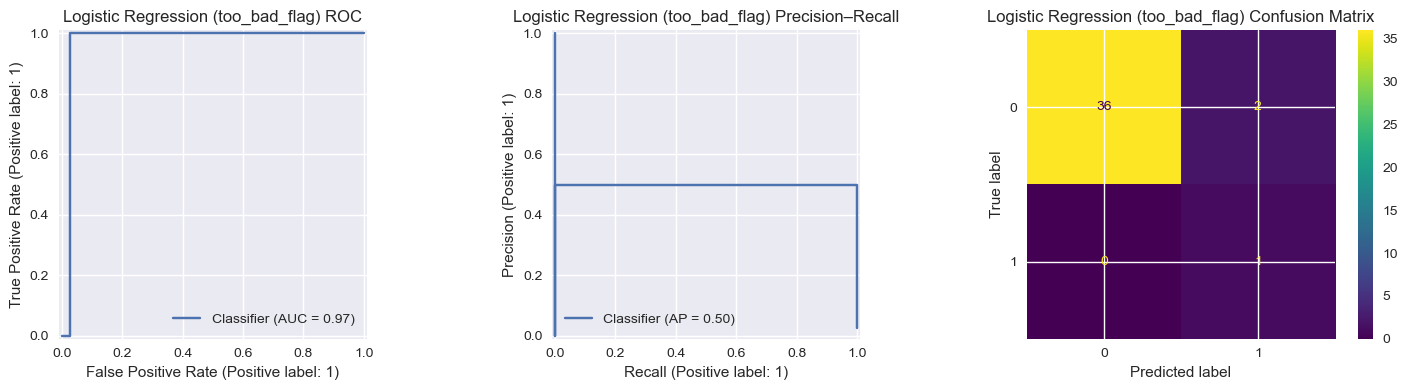

=== Random Forest (too_bad_flag) ===
ROC AUC: 0.9736842105263158

              precision    recall  f1-score   support

           0      0.974     0.974     0.974        38
           1      0.000     0.000     0.000         1

    accuracy                          0.949        39
   macro avg      0.487     0.487     0.487        39
weighted avg      0.949     0.949     0.949        39



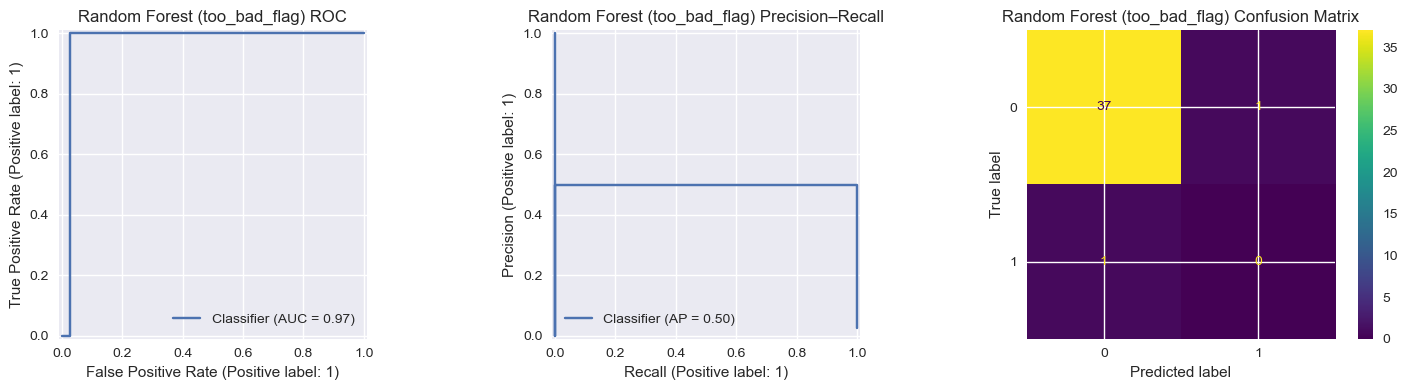

In [41]:
# Define "too bad" as worst 5% of launch conditions
q = 0.95
thr = df["severity_score"].quantile(q)

df["too_bad_flag"] = (df["severity_score"] >= thr).astype(int)

print(f"Severity threshold (q={q}):", thr)
print(df["too_bad_flag"].value_counts())


target_col2 = "too_bad_flag"  # synthetic target based on severity_score
print(df[target_col2].value_counts())

df_model2 = df.dropna(subset=[target_col2] + numeric_features).copy()
X2 = df_model2[all_feature_cols]
y2 = df_model2[target_col2].astype(int)

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.25, random_state=42, stratify=y2
)

log_reg_clf2 = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs"
    )),
])

rf_clf2 = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        class_weight="balanced",
        min_samples_leaf=2
    )),
])

log_reg_clf2.fit(X2_train, y2_train)
rf_clf2.fit(X2_train, y2_train)

evaluate_model(log_reg_clf2, "Logistic Regression (too_bad_flag)")
evaluate_model(rf_clf2, "Random Forest (too_bad_flag)")


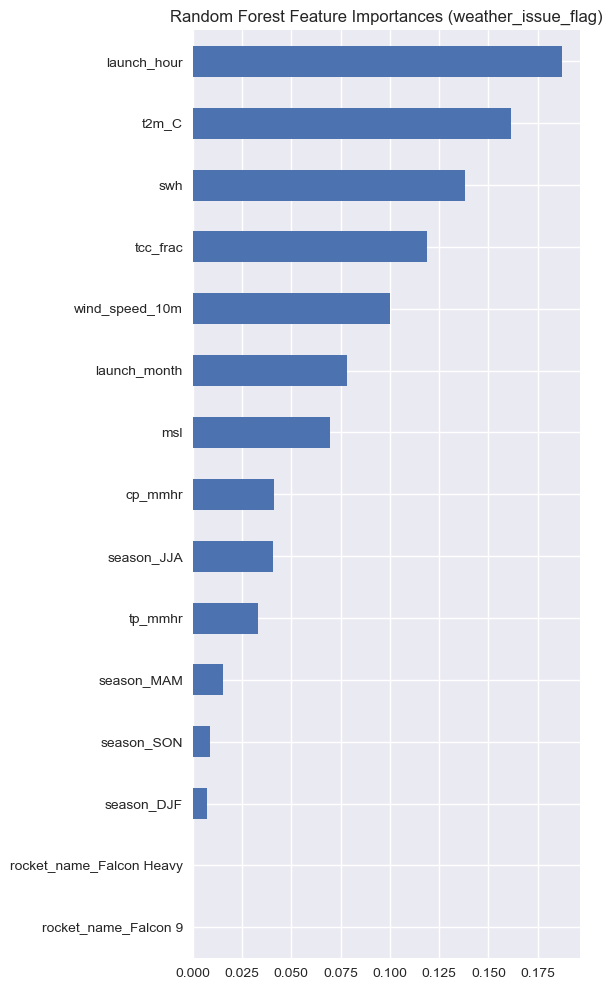

launch_hour       0.187063
t2m_C             0.161521
swh               0.138328
tcc_frac          0.118966
wind_speed_10m    0.100231
launch_month      0.078111
msl               0.069522
cp_mmhr           0.041127
season_JJA        0.040856
tp_mmhr           0.033133
dtype: float64

In [42]:
rf = rf_clf.named_steps["clf"]

rf_importances = pd.Series(
    rf.feature_importances_,
    index=feature_names
)

rf_importances.sort_values().plot(kind="barh", figsize=(6, 10))
plt.title("Random Forest Feature Importances (weather_issue_flag)")
plt.tight_layout()
plt.show()

rf_importances.sort_values(ascending=False).head(10)


In [43]:
df["severity_score"].describe(percentiles=[0.5, 0.9, 0.95, 0.99])


count    154.000000
mean       1.387143
std        0.502242
min        0.346587
50%        1.457336
90%        1.955811
95%        2.160327
99%        2.565173
max        2.652950
Name: severity_score, dtype: float64

In [44]:
def predict_weather_issue_probability(model, conditions: dict) -> float:
    """
    conditions: dict of feature_name -> value for a hypothetical launch.
    Must include all numeric_features and any relevant categorical (e.g., rocket_name, season).
    """
    row = {col: np.nan for col in all_feature_cols}
    row.update(conditions)
    X_new = pd.DataFrame([row])
    prob = model.predict_proba(X_new)[0, 1]
    return prob


In [ ]:
from pathlib import Path
import joblib

Path("models").mkdir(exist_ok=True)

joblib.dump(log_reg_clf2, "models/lr_near_envelope_q95.joblib")


['models/lr_near_envelope_q95.joblib']

In [ ]:
# Marker to push to repository, showing this cell is complete for ATMS 523